# The Applications of Large Language Models on Measuring Central Bank Sentiment

In [47]:
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
import json
import textwrap
from sklearn.metrics import f1_score
from pathlib import Path
import testing as tst
from talib import MA as ma

### SPX on Press Conference Days

[*********************100%%**********************]  1 of 1 completed


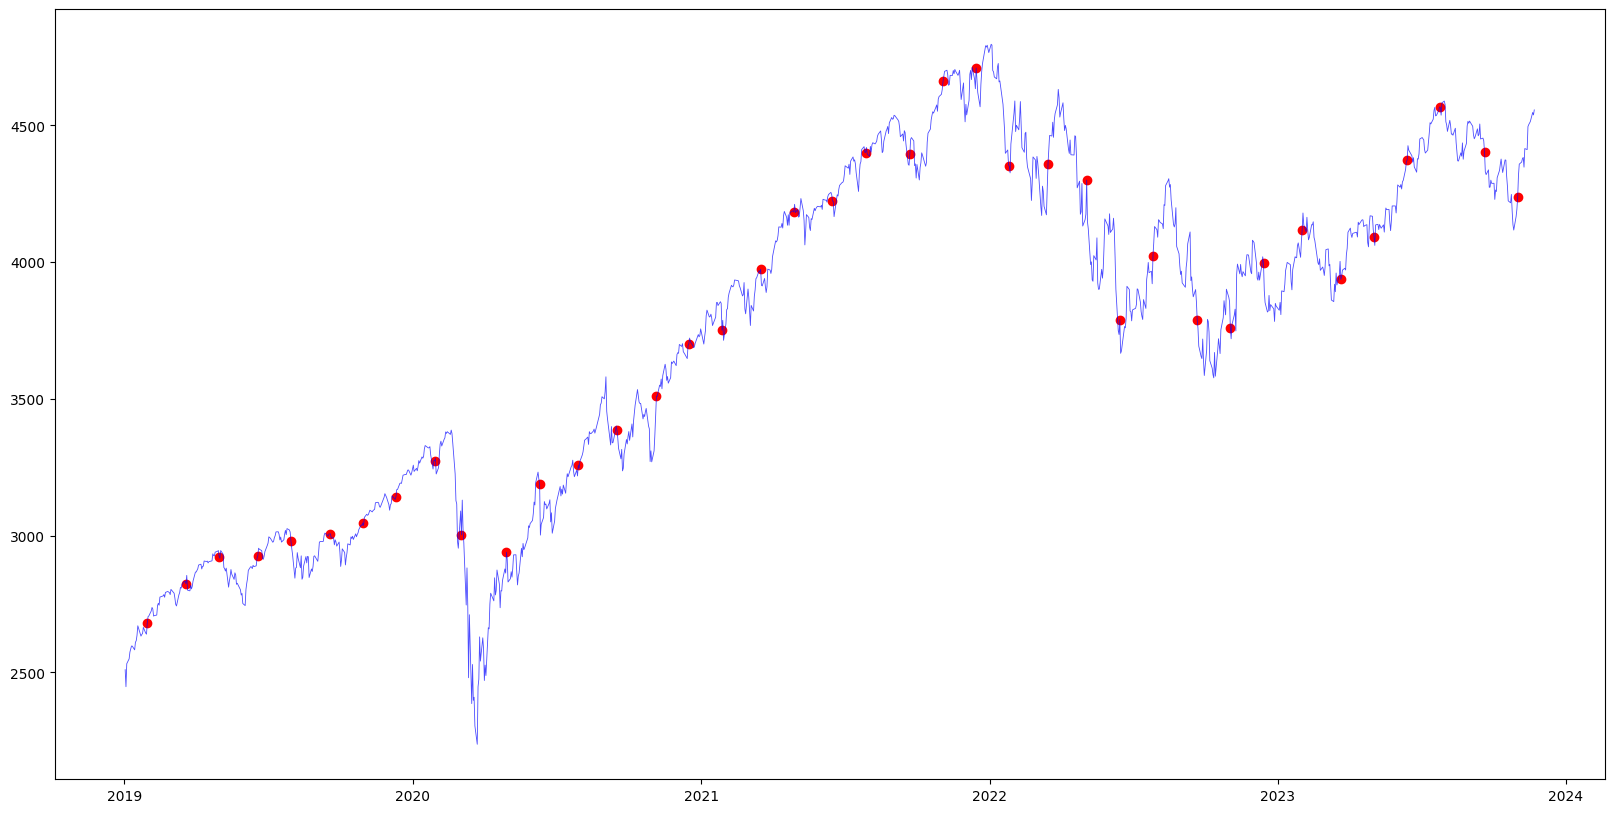

In [2]:
start = pd.Timestamp("2019-01-01")
pc_dates = pd.read_parquet("data/data_scraping/scraped_data/press_conferences.parquet").loc[start:,:].index
spx = yf.download("^SPX", start = start)
spx_pc = spx.loc[[date for date in pc_dates if date in spx.index]]

fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(spx["Close"], color = "blue", alpha = 0.7, lw = 0.6)
ax.scatter(spx_pc["Close"].index, spx_pc["Close"].values, color = "red")

### Standard Deviation of Returns

In [3]:
spx_std = spx.loc[[date for date in spx.index if date not in spx_pc.index]]["Close"].pct_change().std()

spx_pc_std = spx["Close"].loc[
    [spx.index[i-1] for i in range(len(spx)) if spx.index[i] in spx_pc.index] 
    + list(spx_pc.index)
    ].sort_index().pct_change().std()

print(
f"""
Standard Deviation of Returns on Non Press Conference Days: {round(spx_std*100, 2)}%
Standard Deviation of Returns on Press Conference Days: {round(spx_pc_std*100, 2)}%
"""
)


Standard Deviation of Returns on Non Press Conference Days: 1.37%
Standard Deviation of Returns on Press Conference Days: 3.44%



### Data Scraping

In [4]:
speeches = pd.read_parquet("data/results/fine_tune_prompt_2/fine_tune_prompt_2_speeches.parquet")
press_conferences = pd.read_parquet("data/results/fine_tune_prompt_2/fine_tune_prompt_2_press_conferences.parquet")

In [5]:
speeches.iloc[:,:4].head(30)

,speaker,title,link,text
date,,,,
2006-12-15,Chairman Ben S. Bernanke,The Chinese Economy: Progress and Challenges,/newsevents/speech/bernanke20061215a.htm,[The emergence of China as a global economic p...
2006-12-01,Chairman Ben S. Bernanke,Welcoming remarks,/newsevents/speech/bernanke20061201a.htm,"[Vice President Papademos, ladies and gentleme..."
2006-12-01,Vice Chairman Donald L. Kohn,Monetary Policy and Uncertainty,/newsevents/speech/kohn20061201a.htm,[Tonight I will talk about one of the themes o...
2006-11-30,Governor Susan Schmidt Bies,A U.S. Perspective on Basel II Implementation,/newsevents/speech/bies20061130a.htm,"[Good afternoon., Thank you for the invitation..."
2006-11-28,Chairman Ben S. Bernanke,The Economic Outlook,/newsevents/speech/bernanke20061128a.htm,"[Thank you for inviting me to speak today., I ..."
2006-11-21,Governor Kevin Warsh,Financial Markets and the Federal Reserve,/newsevents/speech/warsh20061121a.htm,[Thank you for inviting me to speak about the ...
2006-11-16,Governor Randall S. Kroszner,The Conquest of Worldwide Inflation: Currency ...,/newsevents/speech/kroszner20061116a.htm,[ I am delighted to speak at the Cato Monetary...
2006-11-10,Chairman Ben S. Bernanke,Monetary Aggregates and Monetary Policy at the...,/newsevents/speech/bernanke20061110a.htm,[My topic today is the role of monetary aggreg...
2006-11-03,Vice Chairman Donald L. Kohn,The Evolving Role of the Federal Reserve Banks,/newsevents/speech/kohn20061103a.htm,[I am pleased to have the opportunity to speak...


In [6]:
press_conferences.iloc[:, :2].head(30)

,chair,text
date,,
2011-04-27,CHAIRMAN BERNANKE,"[Good afternoon., Welcome., April 27, 2011 In ..."
2011-06-22,CHAIRMAN BERNANKE,"[Good afternoon and welcome., June 22, 2011 In..."
2011-11-02,CHAIRMAN BERNANKE,"[Good afternoon, everybody., Welcome., In my o..."
2012-01-25,CHAIRMAN BERNANKE,"[Good afternoon and welcome., In my opening re..."
2012-04-25,CHAIRMAN BERNANKE,"[Good afternoon., Before we get to questions, ..."
2012-06-20,CHAIRMAN BERNANKE,"[Good afternoon., Before we get to questions, ..."
2012-09-13,CHAIRMAN BERNANKE,"[Good afternoon., Earlier today the Federal Op..."
2012-12-12,CHAIRMAN BERNANKE,"[Good afternoon., It’s been about three and a ..."
2013-03-20,CHAIRMAN BERNANKE,"[Good afternoon., The Federal Open Market Comm..."


In [7]:
sentences = []
for release in [speeches["text"], press_conferences["text"]]:
    for text in release:
        sentences.extend(text)

In [8]:
len(sentences)

143621

In [9]:
words = []
for sentence in sentences:
    words.extend(sentence.split(" "))


In [10]:
len(words)

3720078

### Perform Textual Analysis With ChatGPT

In [11]:
def auto_split_lines(text, width=80):
    wrapped_lines = textwrap.wrap(text, width=width)
    wrapped_text = "\n".join(wrapped_lines)
    return wrapped_text

In [12]:
with open("data/prompts/zero_shot_prompt_1.txt", "r") as file:
    prompt = file.read().splitlines()

In [13]:
print(
    "Instruction 1:\n" 
    + auto_split_lines(prompt[0], 80)
    + "\n\n"
    + "Instruction 2:\n" 
    + auto_split_lines(prompt[1], 80)
    )

Instruction 1:
Disregard all previous prompts. You are an expert sentence classifier. The
following sentence is from FOMC. Return a short (less than 50 words) explanation
of what its implications are on US monetary policy. Your answer must contain the
word 'hawkish' ,'dovish', 'neutral' or 'irrelevant' in it. Start your
explanation with 'This sentence'. The sentence:

Instruction 2:
Given the previous prompt and your answer to it, classify the sentence into
'HAWKISH', 'DOVISH', 'NEUTRAL' or 'IRRELEVANT' class. Return the label as one
word


In [14]:
with open("data/results/zero_shot_prompt_1/gpt-3.5-turbo/press_conferences/gpt-3.5-turbo_prompt_1_FOMCpresconf20230920.json", "r") as file:
    example_pc = json.load(file)

In [15]:
label_dict = {0: "DOVISH", 1: "HAWKISH", 2: "NEUTRAL"}

In [16]:
print(
    "Example input:\n"
    + auto_split_lines(example_pc[5]["sentence"])
    + "\n\n"
    + "Example analysis:\n"
    + auto_split_lines(example_pc[5]["reason"])
    + "\n\n"
    + "Example label:\n"
    + auto_split_lines(label_dict[example_pc[5]["label"]])
    )

Example input:
Since early last year, the FOMC has significantly tightened the stance of
monetary policy.

Example analysis:
This sentence indicates that the FOMC has adopted a hawkish stance on US
monetary policy since early last year, implying a shift towards tighter monetary
measures.

Example label:
HAWKISH


In [17]:
for sentence in example_pc[10:15]:
    print(
        "Sentence\n"
        + auto_split_lines(sentence["sentence"])
        + "\n\n"
        + "Reason\n"
        + auto_split_lines(sentence["reason"])
        + "\n\n"
        + "Label:\n"
        + auto_split_lines(label_dict[sentence["label"]])
        + "\n\n"
    )

Sentence
I will have more to say about monetary policy after briefly reviewing economic
developments.

Reason
This sentence suggests a neutral stance on US monetary policy as it indicates
that the speaker will provide further insights after assessing economic
developments. It does not provide any indication of a hawkish or dovish bias,
making it irrelevant to immediate policy implications.

Label:
NEUTRAL


Sentence
Recent indicators suggest that economic activity has been expanding at a solid
pace, and, so far this year, growth in real GDP has come in above expectations.

Reason
This sentence suggests a hawkish stance on US monetary policy as it indicates
that the recent indicators show a solid pace of economic expansion and growth in
real GDP exceeding expectations. This implies that the Federal Reserve may
consider tightening monetary policy to prevent potential overheating of the
economy.

Label:
HAWKISH


Sentence
Recent readings on consumer spending have been particul arly robust

### Fine Tune Model

In [18]:
training_data = pd.read_csv("data/training/training_data/training_data.csv", usecols= ["sentence", "label"])

In [19]:
training_data.head(10)

,sentence,label
0,But monetary policy has little ability to affe...,2
1,"Indeed, how will we measure inflation, and the...",2
2,"Unfortunately, from the point of view of both ...",2
3,Productivity change for this output concept ha...,0
4,"Since inflation is unacceptably high, it doesn...",1
5,"This week, the Federal Open Market Committee (...",1
6,"Today, the Federal Reserve's duties fall into ...",2
7,This allows the economy to operate at a higher...,2
8,Some of the increase in sentiment and changes ...,0
9,"Countries differ in this regard, both in forma...",2


In [20]:
len(training_data)

2514

In [21]:
tdw_results = pd.read_csv("data/results/trillion_dollar_words_results.csv")
tdw_results

,Model,MM,MM-S,PC,PC-S,SP,SP-S,Combined,Combined-S
0,Rule-Based,0.5216,0.5200,0.4927,0.5114,0.5449,0.5388,0.4966,0.5165
1,LSTM,0.4982,0.5192,0.3373,0.2877,0.4828,0.5352,0.4917,0.5247
2,Bi-LSTM,0.4906,0.5175,0.3321,0.3186,0.5296,0.5106,0.5387,0.5089
3,BERT-base-uncased,0.5889,0.6115,0.4676,0.5227,0.6151,0.6007,0.6310,0.6360
4,FinBERT-base,0.6173,0.6486,0.4631,0.5452,0.6595,0.6291,0.6325,0.6304
5,FLANG-BERT-base,0.6334,0.6360,0.4647,0.5132,0.6412,0.6355,0.6307,0.6443
6,FLANG-RoBERTa,0.6446,0.6854,0.4995,0.4666,0.6745,0.5561,0.6618,0.6348
7,RoBERTa-base,0.6741,0.6752,0.5371,0.5527,0.6885,0.6725,0.6755,0.6981
8,BERT-large-uncased,0.6843,0.6560,0.4013,0.5231,0.6208,0.6434,0.6579,0.6619
9,RoBERTa-large,0.7150,0.7128,0.5517,0.5346,0.7169,0.7049,0.7171,0.7113


In [23]:
tdw_results.iloc[-2]

Model         RoBERTa-large
MM                    0.715
MM-S                 0.7128
PC                   0.5517
PC-S                 0.5346
SP                   0.7169
SP-S                 0.7049
Combined             0.7171
Combined-S           0.7113
Name: 9, dtype: object

In [24]:
fine_tune_results = [str(path) for path in Path("data/testing/test_results/fine_tune_prompt_2/").glob("*.csv")]
keys = ["sp-", "mm-", "pc-", "combine-"]
results = {} 
for key in keys:
    all_files = [path for path in fine_tune_results if key in path]
    split = [ele for ele in all_files if "split" in ele]
    not_split = [ele for ele in all_files if "split" not in ele]
    split_df = pd.concat([pd.read_csv(path) for path in split])
    not_split_df = pd.concat([pd.read_csv(path) for path in not_split])
    results.update(
        {
            key.upper() + "S" : round(f1_score(split_df.iloc[:,2], split_df.iloc[:, 3], average= "weighted"), 4),
            key[:-1].upper() : round(f1_score(not_split_df.iloc[:, 2], not_split_df.iloc[:, 3], average="weighted"), 4)
        }
    )
    

In [25]:
results

{'SP-S': 0.8562,
 'SP': 0.8511,
 'MM-S': 0.8389,
 'MM': 0.834,
 'PC-S': 0.8529,
 'PC': 0.8457,
 'COMBINE-S': 0.8271,
 'COMBINE': 0.8273}

### Building Hawkishness Index

In [26]:
hawkishness = pd.concat([speeches["hawk_score_1"], press_conferences["hawk_score_1"]]).dropna().sort_index()
rate = tst.get_fred("DGS5")[hawkishness.index[0]:].dropna()
inflation = tst.get_fred("CPIAUCSL").pct_change(12)[hawkishness.index[0]:].dropna()*100

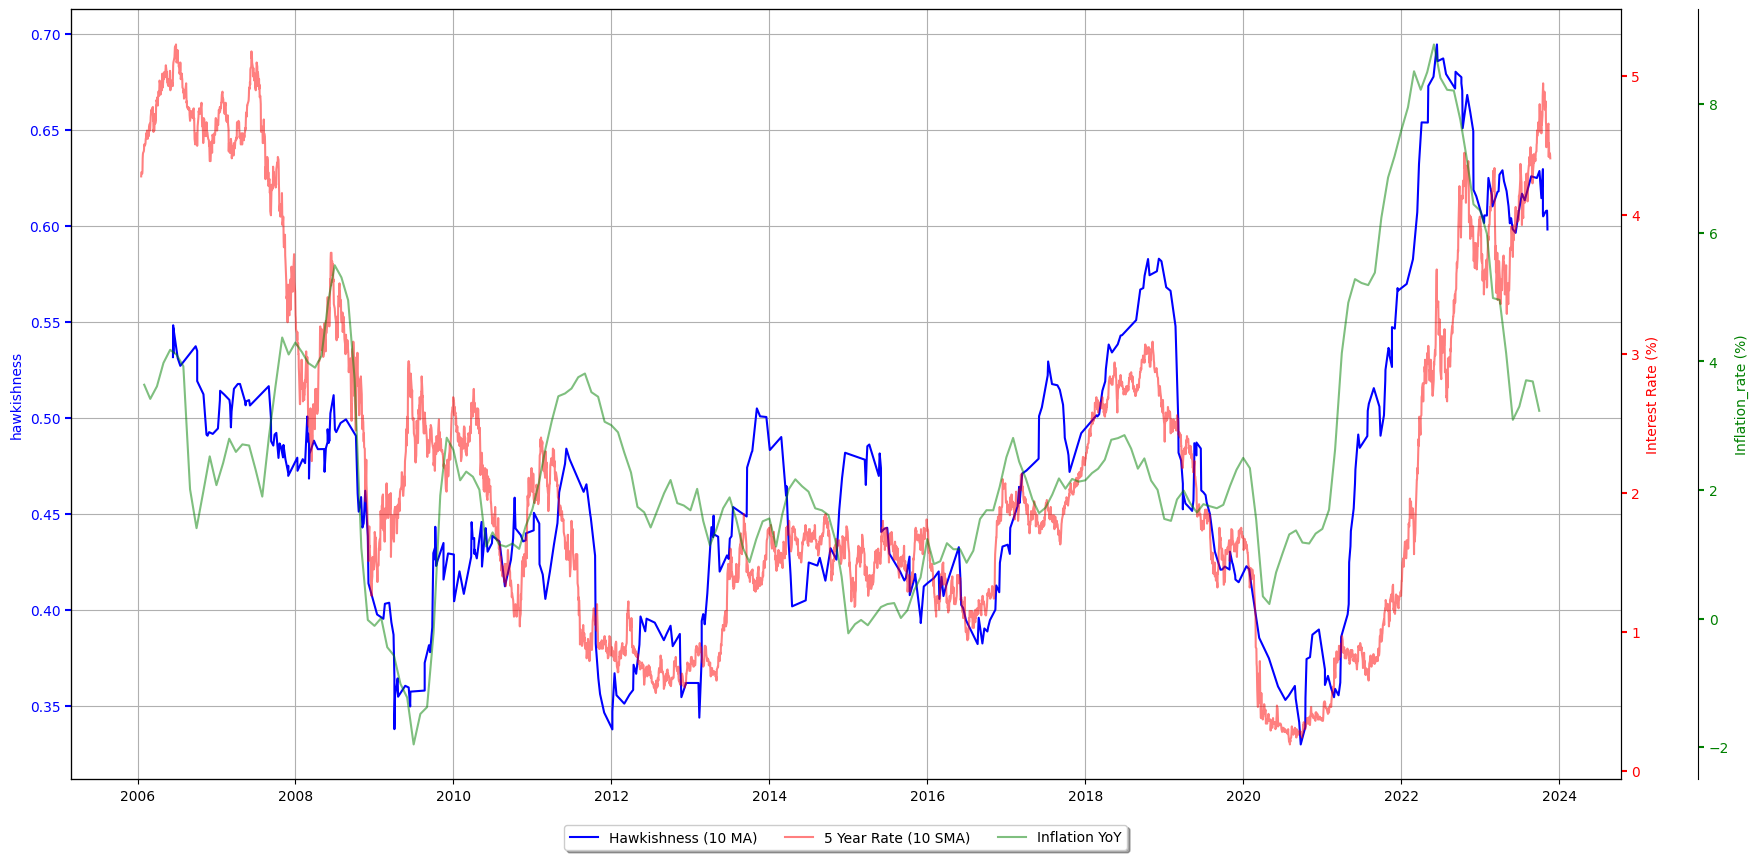

In [27]:
fig, ax = plt.subplots(figsize = (20,10))
ln2, = ax.plot(ma(hawkishness, 10), color = "blue", label = "Hawkishness (10 MA)")
ax2 = ax.twinx()
ln3, = ax2.plot(rate, color = "red", label = "5 Year Rate (10 SMA)", alpha = 0.5)
ax3 = ax.twinx()
ax3.spines.right.set_position(("axes", 1.05))
ln4, = ax3.plot(inflation, color = "green", label = "Inflation YoY", alpha = 0.5)
lns = [ln2, ln3, ln4]
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.set_ylabel("hawkishness")
ax2.set_ylabel("Interest Rate (%)")
ax3.set_ylabel("Inflation_rate (%)")
ax.yaxis.label.set_color(ln2.get_color())
ax2.yaxis.label.set_color(ln3.get_color())
ax3.yaxis.label.set_color(ln4.get_color())
tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=ln2.get_color(), **tkw)
ax2.tick_params(axis='y', colors=ln3.get_color(), **tkw)
ax3.tick_params(axis='y', colors=ln4.get_color(), **tkw)
ax.grid(True)
ax2.grid(False)
ax3.grid(False)

### Correlation and Regression Results

In [29]:
two_year = 1 + tst.get_fred("DGS2")[hawkishness.index[0]:].dropna()/100
five_year = 1 + tst.get_fred("DGS5")[hawkishness.index[0]:].dropna()/100
inflation = 1 + tst.get_fred("CPIAUCSL").pct_change(12)[hawkishness.index[0]:].dropna()
unemployment = 1 + tst.get_fred('UNRATE')[hawkishness.index[0]:].dropna()/100

In [38]:
corr_df_logs = tst.get_correlation_df(hawkishness, two_year, True, range(10, 101, 10), range(-60, 61, 10))
corr_df_levels = tst.get_correlation_df(hawkishness, two_year, False, range(10,101,10), range(-60,61,10))
df_log_max_corr_loc = tst.get_loc_max(corr_df_logs)
df_log_max_corr = corr_df_logs.loc[df_log_max_corr_loc]
df_level_max_corr_loc = tst.get_loc_max(corr_df_levels)
df_level_max_corr = corr_df_levels.loc[df_level_max_corr_loc]

In [39]:
print(f"Max Level Corr:\nLoc:{df_level_max_corr_loc}\nValue: {df_level_max_corr}\n\n")
print(f"Max Log Corr:\nLoc:{df_log_max_corr_loc}\nValue: {df_log_max_corr}\n\n")

Max Level Corr:
Loc:('shift_-40', 'ma_50')
Value: 0.9499702524038067


Max Log Corr:
Loc:('shift_-60', 'ma_70')
Value: 0.2837118272761346




In [40]:
rsquared_df = tst.get_regression_df("two_year", hawkishness, True, range(10,101,10), range(-60,61,10), "rsquared", two_year = two_year, inflation = inflation, unemployment = unemployment)
rsquared_df

,ma_10,ma_20,ma_30,ma_40,ma_50,ma_60,ma_70,ma_80,ma_90,ma_100
shift_-60,0.069935,0.071246,0.090952,0.109619,0.115943,0.12481,0.145194,0.140467,0.115467,0.089287
shift_-50,0.036818,0.040978,0.054339,0.048224,0.067234,0.097579,0.08517,0.104963,0.085165,0.060612
shift_-40,0.061228,0.054649,0.073729,0.06945,0.090561,0.093217,0.103007,0.099676,0.052951,0.047982
shift_-30,0.030169,0.034091,0.050201,0.070189,0.060798,0.068373,0.072841,0.048254,0.048979,0.034371
shift_-20,0.107804,0.113945,0.119856,0.128598,0.133665,0.136537,0.148573,0.175169,0.162316,0.161529
shift_-10,0.047288,0.049864,0.055068,0.06181,0.082921,0.06416,0.103596,0.063615,0.046777,0.043924
shift_0,0.07614,0.068351,0.078114,0.07728,0.120113,0.088431,0.117268,0.070834,0.067595,0.057278
shift_10,0.019146,0.027301,0.033733,0.044153,0.076755,0.06205,0.071398,0.046628,0.037756,0.031051
shift_20,0.040616,0.047643,0.055823,0.065524,0.09028,0.080642,0.096534,0.074487,0.047154,0.059983
shift_30,0.027308,0.037224,0.042338,0.054386,0.076693,0.070709,0.090995,0.024115,0.012108,0.014757


In [41]:
rsquared_loc = tst.get_loc_max(rsquared_df)
print(f"Max R2:\nLoc:{rsquared_loc}\nValue: {rsquared_df.loc[rsquared_loc]}")

Max R2:
Loc:('shift_-20', 'ma_80')
Value: 0.17516876792067537


In [42]:
aic_df = tst.get_regression_df("two_year", hawkishness, True, range(10,101,10), range(-60, 61, 10), "aic", two_year = two_year, inflation = inflation, unemployment = unemployment)
aic_df

,ma_10,ma_20,ma_30,ma_40,ma_50,ma_60,ma_70,ma_80,ma_90,ma_100
shift_-60,-4620.872206,-4511.938239,-4411.712916,-4312.143995,-4218.811913,-4137.563763,-4061.097749,-3998.408198,-3911.561619,-3790.615535
shift_-50,-4581.898399,-4474.146857,-4369.831272,-4261.76199,-4170.924371,-4149.717331,-4047.294458,-3950.440223,-3882.976183,-3761.970695
shift_-40,-4584.004288,-4471.777041,-4370.775492,-4263.893991,-4171.679253,-4108.194189,-4022.763689,-3919.494611,-3830.713655,-3721.241577
shift_-30,-4484.759105,-4381.789183,-4280.592368,-4183.531006,-4074.011321,-4008.839014,-3917.037785,-3825.289291,-3751.791846,-3637.842806
shift_-20,-4539.363063,-4441.932058,-4336.333099,-4238.461787,-4134.85867,-4054.804825,-3972.46764,-3948.351704,-3852.405252,-3738.666485
shift_-10,-4493.744773,-4394.457629,-4296.050988,-4214.612091,-4119.935865,-4042.011212,-4000.484759,-3904.036752,-3803.360758,-3689.207736
shift_0,-4466.056358,-4363.647323,-4262.429726,-4183.35397,-4103.396765,-4006.304747,-3935.364367,-3862.774142,-3758.559573,-3656.580665
shift_10,-4410.988892,-4311.519693,-4208.026431,-4157.911223,-4082.855609,-4017.80848,-3964.941361,-3881.240132,-3774.94302,-3665.914956
shift_20,-4459.094383,-4355.360666,-4253.353373,-4174.320293,-4082.039545,-4013.951568,-3923.944385,-3835.027705,-3721.541841,-3621.71523
shift_30,-4421.407201,-4322.74237,-4217.989007,-4157.659015,-4071.916075,-4032.835944,-3962.792434,-3871.475358,-3757.604042,-3654.586046


In [43]:
aic_loc = tst.get_loc_min(aic_df)
print(f"Min AIC:\nLoc:{aic_loc}\nValue: {aic_df.loc[aic_loc]}")

Min AIC:
Loc:('shift_-60', 'ma_10')
Value: -4620.8722059331


In [46]:
equal_series = tst.get_equivalent_series(hawkishness, True, 40, -20, two_year = two_year, inflation = inflation, unemployment = unemployment)
ols = tst.get_regression(equal_series["two_year"], equal_series["hawkishness"], equal_series["unemployment"], equal_series["inflation"])
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     20.22
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           3.06e-12
Time:                        18:12:06   Log-Likelihood:                 2123.2
No. Observations:                 415   AIC:                            -4238.
Df Residuals:                     411   BIC:                            -4222.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.266e-06   7.17e-05      0.059      0.953      -0.000       0.000
x1             0.0273      0.008      3.244      0.001       0.011       0.044
x2            -0.0869      0.014     -6.154      0.000      -0.115      -0.059
x3             0.0158      0.023      0.676      0.500      -0.030       0.062
==============================================================================
Omnibus:                       79.481   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              992.712
Skew:                          -0.344   Prob(JB):                    2.72e-216
Kurtosis:                      10.546   Cond. No.                         336.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""